# X-Ray classification project
##### This project aims to create an effective model to classify chest xrays into two categories: normal and pneumonia. The dataset is from [Kaggle](https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia).
##### The images are from pediatric patients of one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou. All chest X-ray imaging was performed as part of patients’ routine clinical care.
#####  The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Kaggle API Key
! mkdir ~/.kaggle
! cp /content/drive/MyDrive/KaggleKey/kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Downloading and unziping the dataset
! kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
! unzip -qq chest-xray-pneumonia.zip
print('Files ready!')

 99% 2.28G/2.29G [00:11<00:00, 184MB/s]
100% 2.29G/2.29G [00:11<00:00, 206MB/s]
Files ready!


In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from keras.preprocessing.image import load_img
from IPython.display import display, Markdown


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.losses import BinaryCrossentropy, CategoricalCrossentropy
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.regularizers import l2

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
! pip install keras-tuner --upgrade
from keras_tuner.tuners import RandomSearch

In [ ]:
# Function to plot the evolution of the accuracy and loss throw epochs
def acc_loss_plot(history, epochs, plot_size=(20, 20)):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  plt.figure(figsize=plot_size)

  ax_1 = plt.subplot(2,2,1)
  plt.plot(acc)
  plt.plot(val_acc)
  plt.title(f'Accuracy Model\nacc: {round(acc[-1], 3)}, val_acc: {round(val_acc[-1], 3)}', fontsize=15)
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['ACC', 'VAL_ACC'], loc='lower right')
  plt.grid(True)
  plt.xticks(range(0,epochs))

  ax_2 = plt.subplot(2,2,2)
  plt.plot(loss)
  plt.plot(val_loss)
  plt.title(f'Loss Model\nloss: {round(loss[-1], 3)}, , val_loss: {round(val_loss[-1], 3)}', fontsize=15)
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend(['LOSS', 'VAL_LOSS'], loc='lower left')
  plt.grid(True)
  plt.xticks(range(0,epochs))
  plt.show()

In [ ]:
def report(predictions, real):
  predictions = np.argmax(predictions, axis=1)
  matrix = confusion_matrix(real, predictions)
  display(Markdown(f'### True Negatives: {matrix[0][0]}'))
  display(Markdown(f'### False Positives: {matrix[0][1]}'))
  display(Markdown(f'### False Negatives: {matrix[1][0]}'))
  display(Markdown(f'### True Positives: {matrix[1][1]}'))
  plt.figure(figsize=(8, 8))
  sns.heatmap(matrix, square=True, annot=True, cbar=False, cmap=plt.cm.Blues, fmt='g')
  plt.title('Matrix de Confusión')
  plt.xlabel('Predicciones')
  plt.ylabel('Etiquetas')
  plt.show()
  print('\n', classification_report(real, predictions))

### Getting one image to see general information

Image type: <class 'PIL.Image.Image'>
Image format:  RGB
Image size: (1857, 1317)


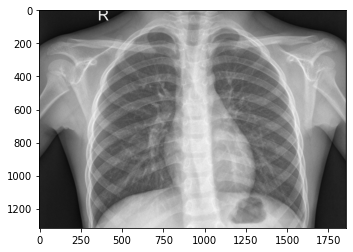

In [ ]:
# load example image
img = load_img('/content/chest_xray/test/NORMAL/IM-0001-0001.jpeg')
# report details about the image
print('Image type:', type(img))
print('Image format: ', img.mode)
print('Image size:', img.size)
# show the image
plt.imshow(img)

In [ ]:
TRAIN_PATH = '/content/chest_xray/train'
VALID_PATH = '/content/chest_xray/val'
TEST_PATH = '/content/chest_xray/test'

normal_count = len(os.listdir(TRAIN_PATH + '/NORMAL'))
pneu_count = len(os.listdir(TRAIN_PATH + '/PNEUMONIA'))

display(Markdown(f'### Normal X-rays in train set: {normal_count}'))
display(Markdown(f'### Pneumonia X-rays in train set: {pneu_count}'))

fig = px.bar(x=['Normal', 'Pneumonia'], y=[normal_count, pneu_count], 
             width=700, title='Number of files in training set')
fig.show()

### Normal X-rays in train set: 1341

### Pneumonia X-rays in train set: 3875

*Note: The train data is clearly unbalance, something to keep in mind when training the net.*

* First Aproach: Loading images with keras tool with no modifications, just rescaling to values from 0.0 to 1.0

In [ ]:
# Function to load images with the option of augment data
def img_generator(batch_size, transformations=False):
    test_datagen = ImageDataGenerator(rescale= 1 / 256.0)
    val_datagen = ImageDataGenerator(rescale= 1 / 256.0)
    
    if transformations:
      train_datagen = ImageDataGenerator(rescale= 1 / 256.0, 
                                         zoom_range=[0.5, 1.5], 
                                         brightness_range=[0.3, 1.5],
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         channel_shift_range=0.8)
    else:
      train_datagen = ImageDataGenerator(rescale= 1 / 256.0)

    train_ds = train_datagen.flow_from_directory(TRAIN_PATH, 
                                                 class_mode='categorical', 
                                                 target_size=(256, 256),
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 seed=42)
    
    valid_ds = val_datagen.flow_from_directory(VALID_PATH, 
                                               class_mode='categorical', 
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               batch_size=batch_size)
    
    test_ds = test_datagen.flow_from_directory(TEST_PATH, 
                                               class_mode='categorical', 
                                               color_mode='rgb',
                                               target_size=(256, 256),
                                               batch_size=batch_size,
                                               shuffle=False)
    return train_ds, valid_ds, test_ds, train_ds.class_indices

In [ ]:
# Using Data Generator tool from Keras library without transformation
batch_size = 36
train_ds, valid_ds, test_ds, classes = img_generator(batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
# Checking the classes identified by the Data Generator
classes

{'NORMAL': 0, 'PNEUMONIA': 1}

TODO: Fix plot title

In [ ]:
# Function to plot a few examples from the data generator
def plot_rxs(ds):
    display(Markdown('### Examples of the training set'))
    plt.figure(figsize=(18, 15))
    images, labels = ds.next()

    rows, cols = 4, 4
    fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
    for i in range(rows):
        for j in range(cols):
            num = 4 * i + j
            img = images[num]
            lbl = labels[num][0]
            title = 'Normal' if lbl == 0 else 'Pneumonia'   
            axes[i, j].imshow(img)
            axes[i, j].set_title(title)

### Examples of the training set

<Figure size 1296x1080 with 0 Axes>

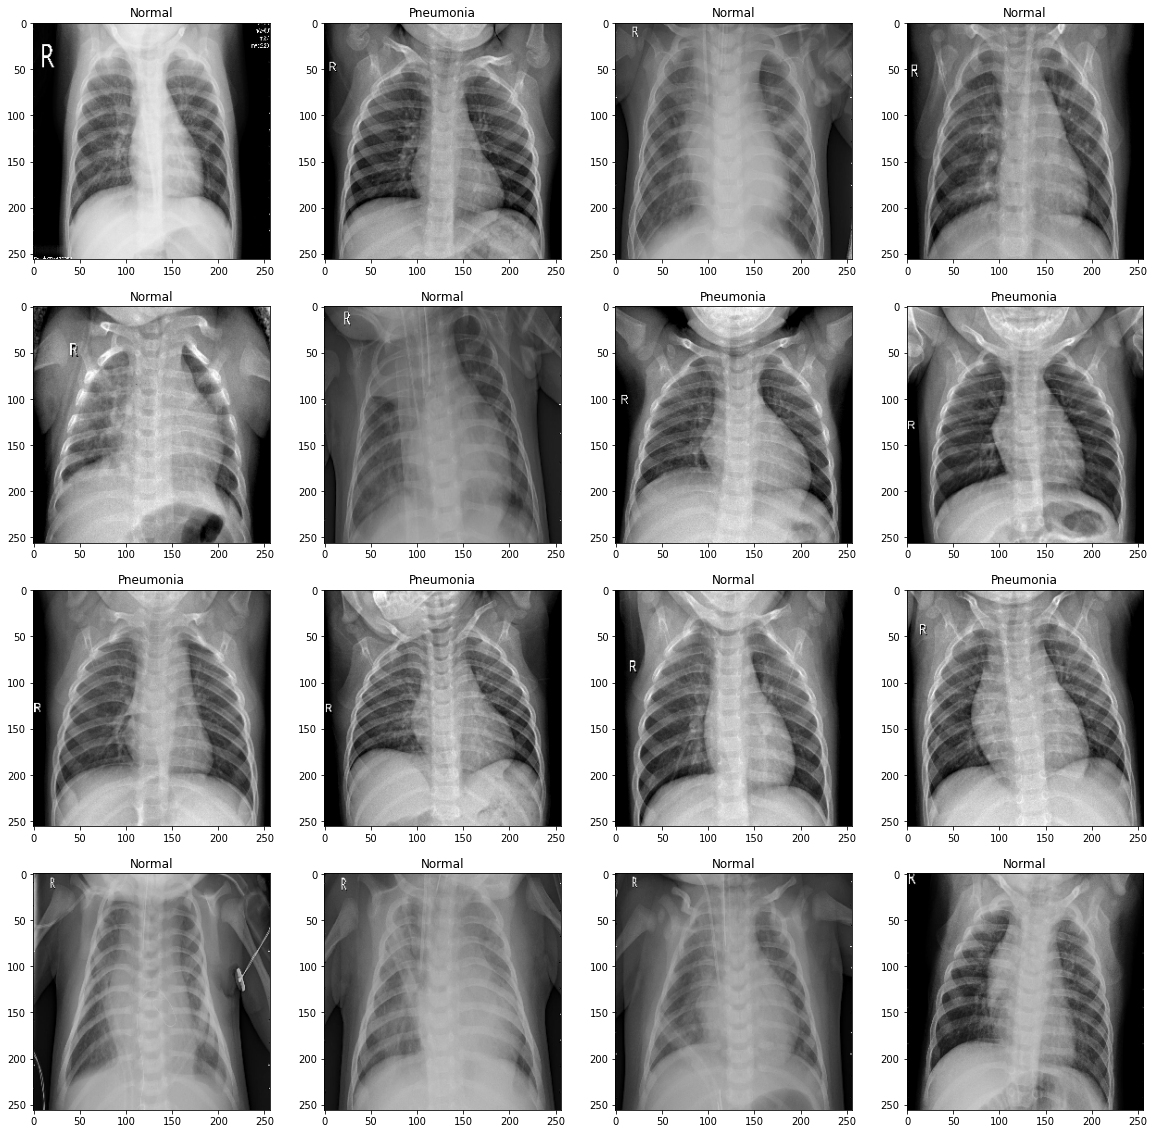

In [ ]:
plot_rxs(train_ds)

Initial Convolutional Neural Network

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(72, (3, 3), padding='same', strides=2, activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 72)        20808     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 72)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 dense (Dense)               (None, 64)                4

In [ ]:
# Reseting the image generator because the first batch was used to plot
train_ds.reset()
epochs = 10

train_steps = train_ds.n // train_ds.batch_size

early_stopping = EarlyStopping(
                        monitor='val_loss',
                        mode='min', min_delta=0.005, 
                        patience=3, verbose=True, 
                        restore_best_weights=True)

history = model.fit(train_ds, epochs=epochs, 
          validation_data=valid_ds, 
          steps_per_epoch=train_steps,
          callbacks=[early_stopping])

Epoch 1/10
144/144 [==============================] - 67s 383ms/step - loss: 0.4626 - accuracy: 0.8629 - val_loss: 0.1275 - val_accuracy: 0.9375
Epoch 2/10
144/144 [==============================] - 53s 370ms/step - loss: 0.1486 - accuracy: 0.9479 - val_loss: 0.2394 - val_accuracy: 0.8125
Epoch 3/10
144/144 [==============================] - 53s 367ms/step - loss: 0.0966 - accuracy: 0.9660 - val_loss: 0.0784 - val_accuracy: 1.0000
Epoch 4/10
144/144 [==============================] - 55s 379ms/step - loss: 0.0939 - accuracy: 0.9737 - val_loss: 0.0575 - val_accuracy: 1.0000
Epoch 5/10
144/144 [==============================] - 54s 376ms/step - loss: 0.0726 - accuracy: 0.9793 - val_loss: 0.0752 - val_accuracy: 1.0000
Epoch 6/10
144/144 [==============================] - 55s 381ms/step - loss: 0.0542 - accuracy: 0.9797 - val_loss: 0.2874 - val_accuracy: 0.8750
Epoch 7/10
144/144 [==============================] - 53s 370ms/step - loss: 0.0379 - accuracy: 0.9865 - val_loss: 0.0182 - val_ac

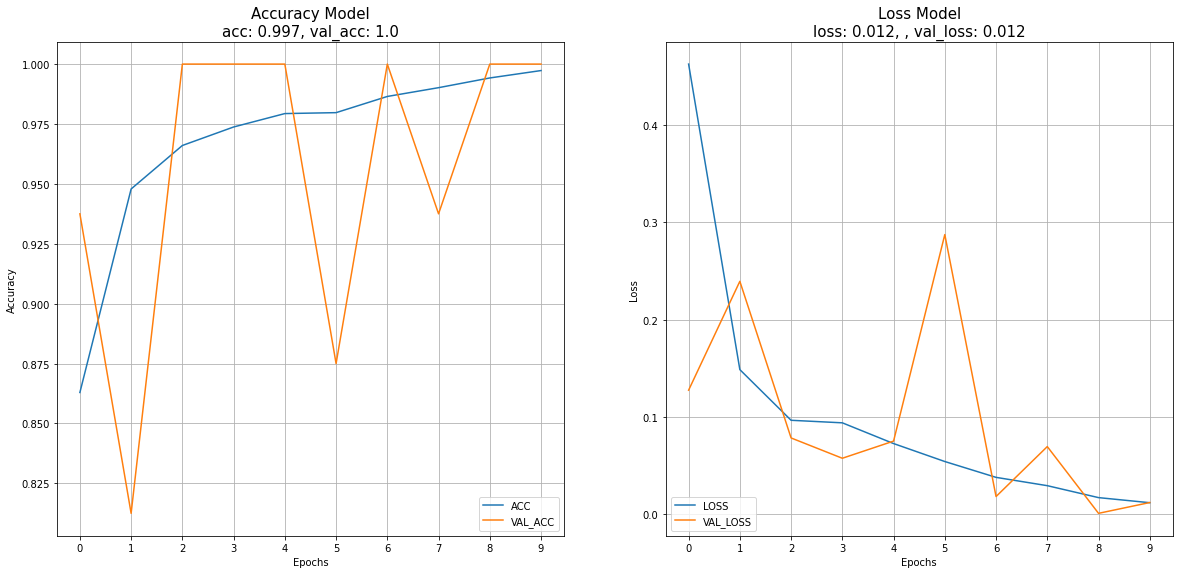

In [ ]:
last_epoch = early_stopping.stopped_epoch if early_stopping.stopped_epoch != 0 else epochs
acc_loss_plot(history, epochs)

### True Negatives: 97

### False Positives: 137

### False Negatives: 1

### True Positives: 389

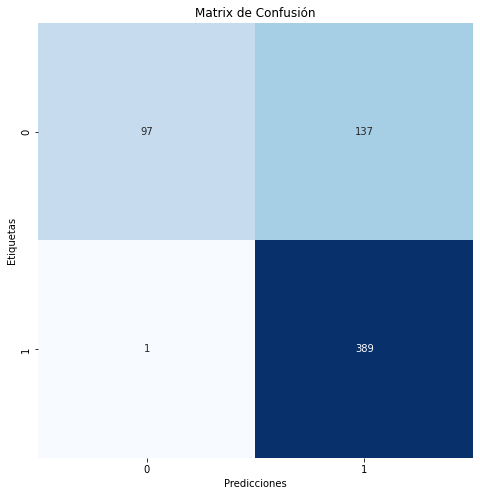


               precision    recall  f1-score   support

           0       0.99      0.41      0.58       234
           1       0.74      1.00      0.85       390

    accuracy                           0.78       624
   macro avg       0.86      0.71      0.72       624
weighted avg       0.83      0.78      0.75       624



In [ ]:
normal_count = len(os.listdir(TEST_PATH + '/NORMAL'))
pneu_count = len(os.listdir(TEST_PATH + '/PNEUMONIA'))
predictions = model.predict(test_ds, (normal_count + pneu_count) // batch_size+1)
report(predictions, test_ds.classes)

### Before trying to add and tune different hyperparameters, I`m going to try to use the class_weigths parameter to modify the "sensitivity" of the loss function depending on the class that is classifying

In [ ]:
class_weights = compute_class_weight(
                    class_weight="balanced",
                    classes=np.unique(train_ds.classes),
                    y=train_ds.classes)
class_weights = dict(enumerate(class_weights))

In [ ]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model.add(MaxPool2D((2, 2)))
model.add(Conv2D(72, (3, 3), padding='same', strides=2, activation='relu'))
model.add(MaxPool2D((2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))

model.compile(optimizer=RMSprop(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

train_ds.reset()
valid_ds.reset()
test_ds.reset()

epochs = 25

train_steps = train_ds.n // train_ds.batch_size

early_stopping = EarlyStopping(
                        monitor='val_loss',
                        mode='min', min_delta=0.005, 
                        patience=3, verbose=True, 
                        restore_best_weights=True)

history = model.fit(train_ds, epochs=epochs, 
          validation_data=valid_ds, 
          steps_per_epoch=train_steps,
          callbacks=[early_stopping],
          class_weight=class_weights)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 72)        20808     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 32, 32, 72)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 73728)             0         
                                                                 
 dense_4 (Dense)             (None, 64)               

In [ ]:
model.evaluate(test_ds)

18/18 [==============================] - 5s 275ms/step - loss: 1.0168 - accuracy: 0.7965


[1.0168342590332031, 0.7964743375778198]

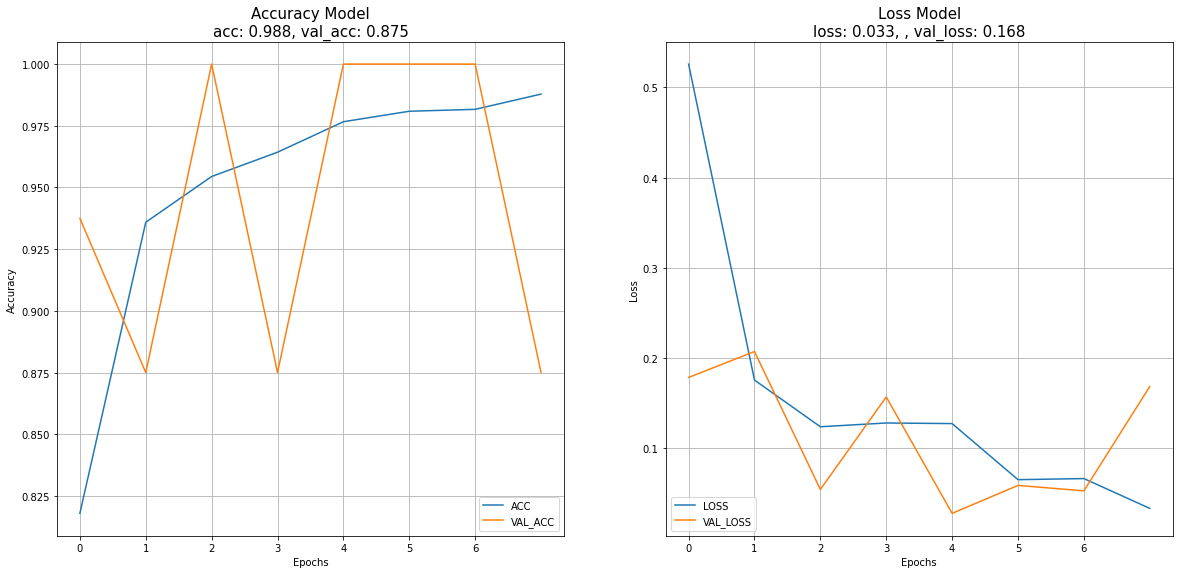

In [ ]:
last_epoch = early_stopping.stopped_epoch if early_stopping.stopped_epoch != 0 else epochs
acc_loss_plot(history, last_epoch)

### True Negatives: 113

### False Positives: 121

### False Negatives: 6

### True Positives: 384

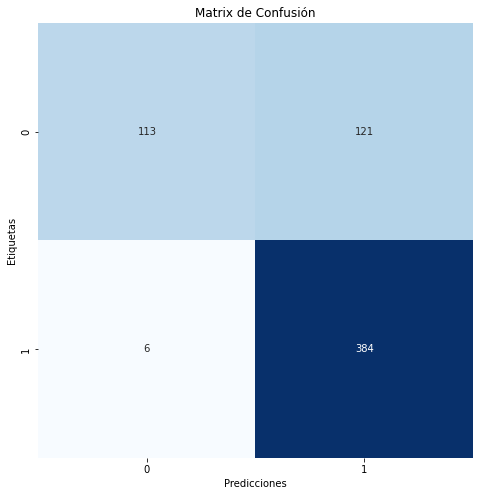


               precision    recall  f1-score   support

           0       0.95      0.48      0.64       234
           1       0.76      0.98      0.86       390

    accuracy                           0.80       624
   macro avg       0.85      0.73      0.75       624
weighted avg       0.83      0.80      0.78       624



In [ ]:
normal_count = len(os.listdir(TEST_PATH + '/NORMAL'))
pneu_count = len(os.listdir(TEST_PATH + '/PNEUMONIA'))
predictions = model.predict(test_ds, (normal_count + pneu_count) // batch_size+1)
report(predictions, test_ds.classes)

#### Improving the network with Keras-Tunner.

In [ ]:
def build_model_function(units_1, units_2, dense_units, filter_size, padding, lr):
    train_ds.reset()
    valid_ds.reset()
    test_ds.reset()
    model = Sequential()
    model.add(Conv2D(units_1, filter_size, padding=padding, activation='relu', input_shape=(256, 256, 3)))
    model.add(MaxPool2D((2, 2)))
    model.add(Conv2D(units_2, filter_size, padding=padding, activation='relu'))
    model.add(Dropout(0.2))
    model.add(MaxPool2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(dense_units, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))


    model.compile(optimizer=RMSprop(lr),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def hyperparameters(hp):
    units_1 = hp.Int('units_1', min_value=32, max_value=76, step=22)
    units_2 = hp.Int('units_2', min_value=32, max_value=128, step=32)
    dense_units = hp.Int('dense_units', min_value=64, max_value=256, step=64)
    filter_size = hp.Choice('filter_size', [3, 5])
    padding = hp.Choice('padding', ['same', 'valid'])
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model = build_model_function(units_1, units_2, dense_units, filter_size, padding, lr)
    return model

In [ ]:
tuner = RandomSearch(
            hypermodel=hyperparameters,
            objective='val_loss',
            max_trials=3,
            executions_per_trial=2,
            overwrite=True,
            directory='hp_tunning')

In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 6
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 76, 'step': 22, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 128, 'step': 32, 'sampling': None}
dense_units (Int)
{'default': None, 'conditions': [], 'min_value': 64, 'max_value': 256, 'step': 64, 'sampling': None}
filter_size (Choice)
{'default': 3, 'conditions': [], 'values': [3, 5], 'ordered': True}
padding (Choice)
{'default': 'same', 'conditions': [], 'values': ['same', 'valid'], 'ordered': False}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [ ]:
epochs = 20

train_steps = train_ds.n // train_ds.batch_size

early_stopping = EarlyStopping(
                        monitor='val_loss',
                        mode='min', min_delta=0.002, 
                        patience=3, verbose=False, 
                        restore_best_weights=True)

tuner.search(train_ds, epochs=epochs, 
          validation_data=valid_ds, 
          steps_per_epoch=train_steps,
          callbacks=[early_stopping],
          class_weight=class_weights)

Trial 3 Complete [00h 10m 52s]
val_loss: 0.44284480810165405

Best val_loss So Far: 0.02026660367846489
Total elapsed time: 00h 46m 04s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in hp_tunning/untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
units_1: 54
units_2: 32
dense_units: 128
filter_size: 3
padding: same
lr: 0.0002712807530369808
Score: 0.02026660367846489
Trial summary
Hyperparameters:
units_1: 54
units_2: 64
dense_units: 192
filter_size: 5
padding: valid
lr: 0.0002256574510240418
Score: 0.10328252613544464
Trial summary
Hyperparameters:
units_1: 32
units_2: 96
dense_units: 128
filter_size: 5
padding: valid
lr: 0.0033634599074899556
Score: 0.44284480810165405


In [ ]:
best_params = tuner.get_best_hyperparameters()[0] 
print(f'Units 1: {best_params.get("units_1")}')
print(f'Units 2: {best_params.get("units_2")}')
print(f'Dense Units: {best_params.get("dense_units")}')
print(f'Filter Size: {best_params.get("filter_size")}')
print(f'Padding: {best_params.get("padding")}')
print(f'Learning Rate: {best_params.get("lr")}')

Units 1: 54
Units 2: 32
Dense Units: 128
Filter Size: 3
Padding: same
Learning Rate: 0.0002712807530369808


In [ ]:
best_model = tuner.get_best_models()[0]

In [ ]:
best_model.evaluate(test_ds)

18/18 [==============================] - 6s 289ms/step - loss: 0.7614 - accuracy: 0.8237


[0.761418342590332, 0.8237179517745972]

### True Negatives: 136

### False Positives: 98

### False Negatives: 12

### True Positives: 378

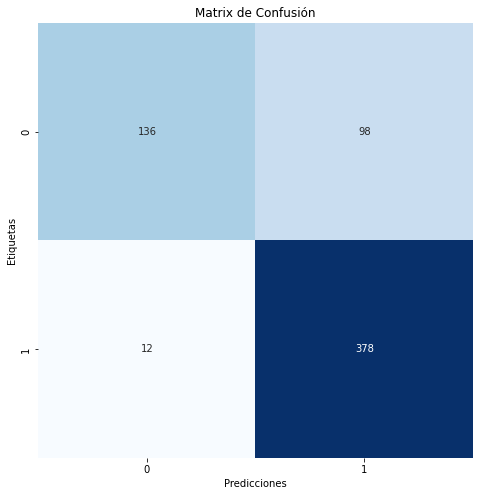


               precision    recall  f1-score   support

           0       0.92      0.58      0.71       234
           1       0.79      0.97      0.87       390

    accuracy                           0.82       624
   macro avg       0.86      0.78      0.79       624
weighted avg       0.84      0.82      0.81       624



In [ ]:
normal_count = len(os.listdir(TEST_PATH + '/NORMAL'))
pneu_count = len(os.listdir(TEST_PATH + '/PNEUMONIA'))
predictions = best_model.predict(test_ds, (normal_count + pneu_count) // batch_size+1)
report(predictions, test_ds.classes)

#### Adding Data Augmentation

In [ ]:
# Using Data Generator tool from Keras library without transformation
batch_size = 36
train_ds_aug, valid_ds_aug, test_ds_aug, classes = img_generator(batch_size, transformations=True)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Examples of the training set

<Figure size 1296x1080 with 0 Axes>

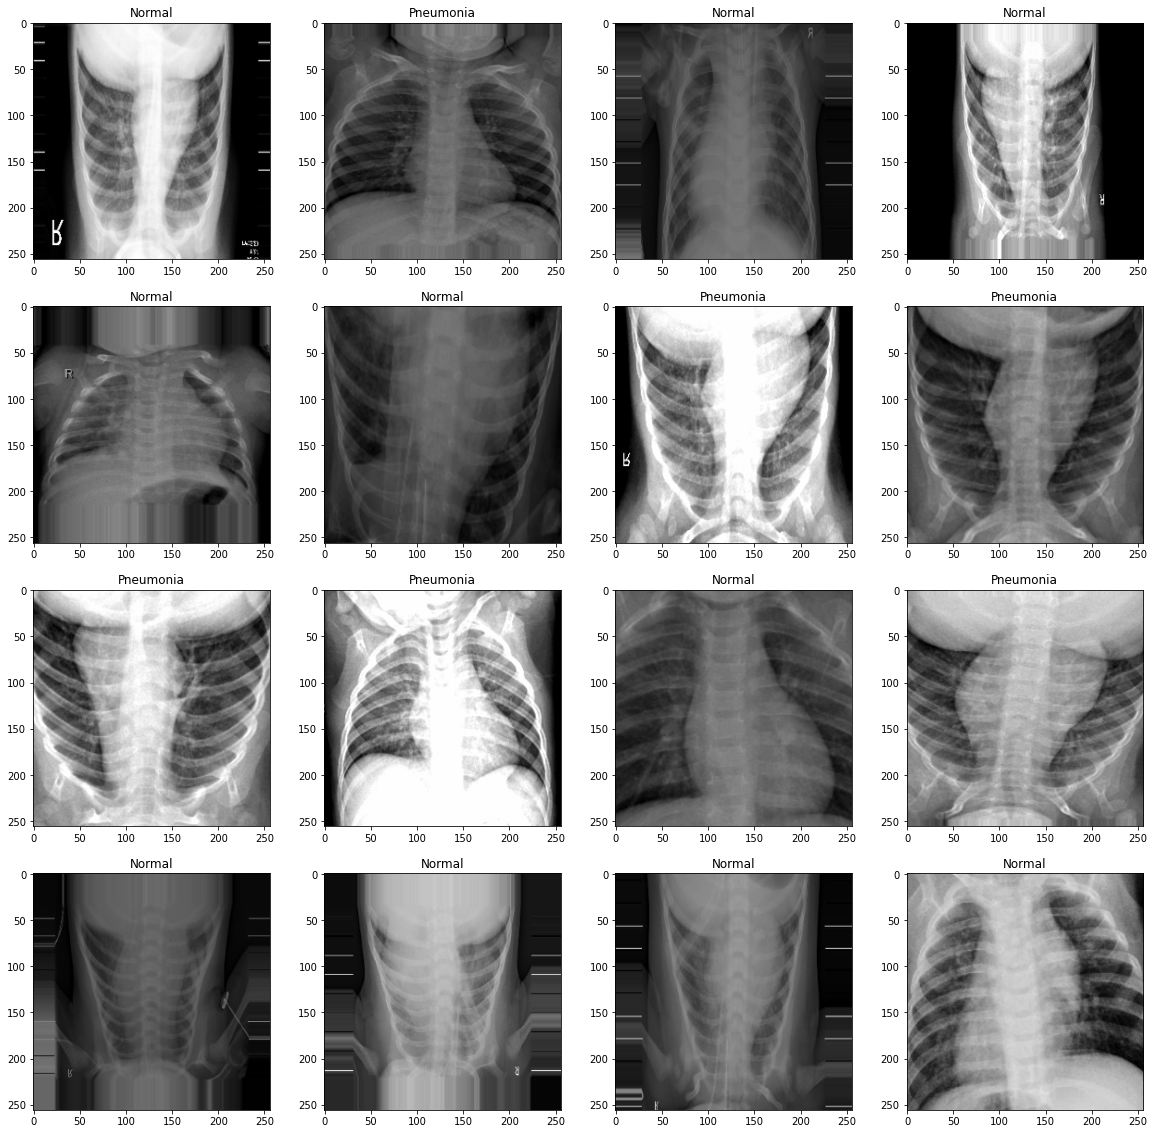

In [ ]:
plot_rxs(train_ds_aug)

In [ ]:
train_ds_aug.reset()
valid_ds_aug.reset()
test_ds_aug.reset()

aug_model = Sequential()
aug_model.add(Conv2D(54, 3, padding='same', activation='relu', input_shape=(256, 256, 3)))
aug_model.add(MaxPool2D((2, 2)))
aug_model.add(Conv2D(32, 3, padding='same', activation='relu'))
aug_model.add(Dropout(0.2))
aug_model.add(MaxPool2D((2, 2)))
aug_model.add(Flatten())
aug_model.add(Dense(128, activation='relu'))
aug_model.add(Dropout(0.2))
aug_model.add(Dense(2, activation='softmax'))


aug_model.compile(optimizer=RMSprop(0.0002),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(
                        monitor='val_loss',
                        mode='min', min_delta=0.002, 
                        patience=5, verbose=True, 
                        restore_best_weights=True)

aug_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 54)      1512      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 54)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      15584     
                                                                 
 dropout (Dropout)           (None, 128, 128, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 131072)            0

In [ ]:
epochs = 20
train_steps = train_ds_aug.n // train_ds_aug.batch_size

history = aug_model.fit(train_ds_aug, epochs=epochs, 
          validation_data=valid_ds_aug, 
          steps_per_epoch=train_steps,
          callbacks=[early_stopping],
          class_weight=class_weights)

Epoch 1/20
144/144 [==============================] - 153s 972ms/step - loss: 0.7899 - accuracy: 0.6579 - val_loss: 0.8323 - val_accuracy: 0.5625
Epoch 2/20
144/144 [==============================] - 134s 931ms/step - loss: 0.4763 - accuracy: 0.7766 - val_loss: 0.3681 - val_accuracy: 0.8750
Epoch 3/20
144/144 [==============================] - 131s 909ms/step - loss: 0.4608 - accuracy: 0.7936 - val_loss: 0.3858 - val_accuracy: 0.8750
Epoch 4/20
144/144 [==============================] - 132s 916ms/step - loss: 0.4370 - accuracy: 0.7969 - val_loss: 0.5467 - val_accuracy: 0.5625
Epoch 5/20
144/144 [==============================] - 133s 922ms/step - loss: 0.4137 - accuracy: 0.8073 - val_loss: 0.3807 - val_accuracy: 0.8125
Epoch 6/20
144/144 [==============================] - 132s 912ms/step - loss: 0.4139 - accuracy: 0.8127 - val_loss: 0.5285 - val_accuracy: 0.6250
Epoch 7/20
144/144 [==============================] - 131s 911ms/step - loss: 0.3996 - accuracy: 0.8189 - val_loss: 0.6687 -

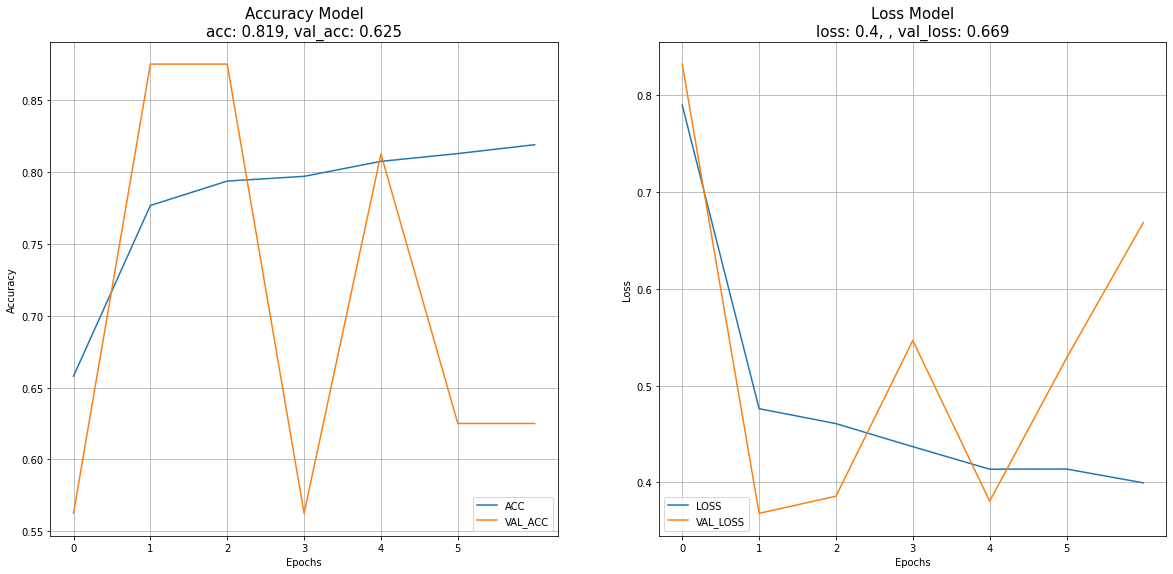

In [ ]:
last_epoch = early_stopping.stopped_epoch if early_stopping.stopped_epoch != 0 else epochs
acc_loss_plot(history, last_epoch)

In [ ]:
aug_model.evaluate(test_ds_aug)

18/18 [==============================] - 6s 300ms/step - loss: 0.4546 - accuracy: 0.7740


[0.4546169340610504, 0.7740384340286255]

### True Negatives: 216

### False Positives: 18

### False Negatives: 123

### True Positives: 267

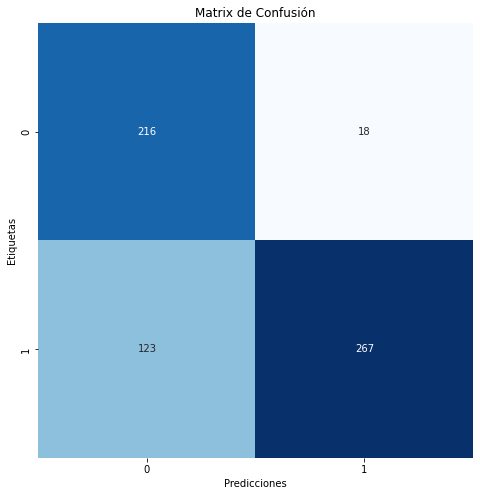


               precision    recall  f1-score   support

           0       0.64      0.92      0.75       234
           1       0.94      0.68      0.79       390

    accuracy                           0.77       624
   macro avg       0.79      0.80      0.77       624
weighted avg       0.82      0.77      0.78       624



In [ ]:
normal_count = len(os.listdir(TEST_PATH + '/NORMAL'))
pneu_count = len(os.listdir(TEST_PATH + '/PNEUMONIA'))
predictions = aug_model.predict(test_ds_aug, (normal_count + pneu_count) // batch_size+1)
report(predictions, test_ds_aug.classes)

## Transfer Learning

In [ ]:
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras.applications.efficientnet_v2 import EfficientNetV2L
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras import Model
base_model = EfficientNetV2L(include_top=False,  input_shape=(256, 256, 3))
base_model.trainable = False

82436096/82420632 [==============================] - 1s 0us/step


In [ ]:
inputs = Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)

tnsf_model = Model(inputs, outputs)

In [ ]:
tnsf_model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

tnsf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetv2-s (Functiona  (None, 8, 8, 1280)       20331360  
 l)                                                              
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026  

In [ ]:
train_ds_aug.reset()
valid_ds_aug.reset()

epochs = 20

train_steps = train_ds.n // train_ds.batch_size

early_stopping = EarlyStopping(
                        monitor='val_loss',
                        mode='min', min_delta=0.002, 
                        patience=5, verbose=True, 
                        restore_best_weights=True)

tb_callback = TensorBoard('./logs', update_freq=1)

last_epoch = early_stopping.stopped_epoch if early_stopping.stopped_epoch != 0 else epochs

tnsf_history = tnsf_model.fit(train_ds_aug, epochs=epochs, 
                        validation_data=valid_ds_aug, 
                        steps_per_epoch=train_steps,
                        callbacks=[early_stopping, tb_callback],
                        class_weight=class_weights)

Epoch 1/20
144/144 [==============================] - 203s 1s/step - loss: 0.6326 - accuracy: 0.5952 - val_loss: 0.7386 - val_accuracy: 0.5625
Epoch 2/20
144/144 [==============================] - 155s 1s/step - loss: 0.5917 - accuracy: 0.6569 - val_loss: 0.7363 - val_accuracy: 0.6875
Epoch 3/20
144/144 [==============================] - 155s 1s/step - loss: 0.5679 - accuracy: 0.6836 - val_loss: 0.7127 - val_accuracy: 0.5625
Epoch 4/20
144/144 [==============================] - 154s 1s/step - loss: 0.5664 - accuracy: 0.6934 - val_loss: 0.7205 - val_accuracy: 0.5000
Epoch 5/20
144/144 [==============================] - 155s 1s/step - loss: 0.5764 - accuracy: 0.6803 - val_loss: 0.6600 - val_accuracy: 0.6250
Epoch 6/20
144/144 [==============================] - 154s 1s/step - loss: 0.5452 - accuracy: 0.7154 - val_loss: 0.7160 - val_accuracy: 0.6875
Epoch 7/20
144/144 [==============================] - 154s 1s/step - loss: 0.5449 - accuracy: 0.7112 - val_loss: 0.6963 - val_accuracy: 0.6875

In [ ]:
tnsf_model.evaluate(test_ds_aug)

18/18 [==============================] - 12s 642ms/step - loss: 0.4829 - accuracy: 0.7756


[0.4829402267932892, 0.7756410241127014]

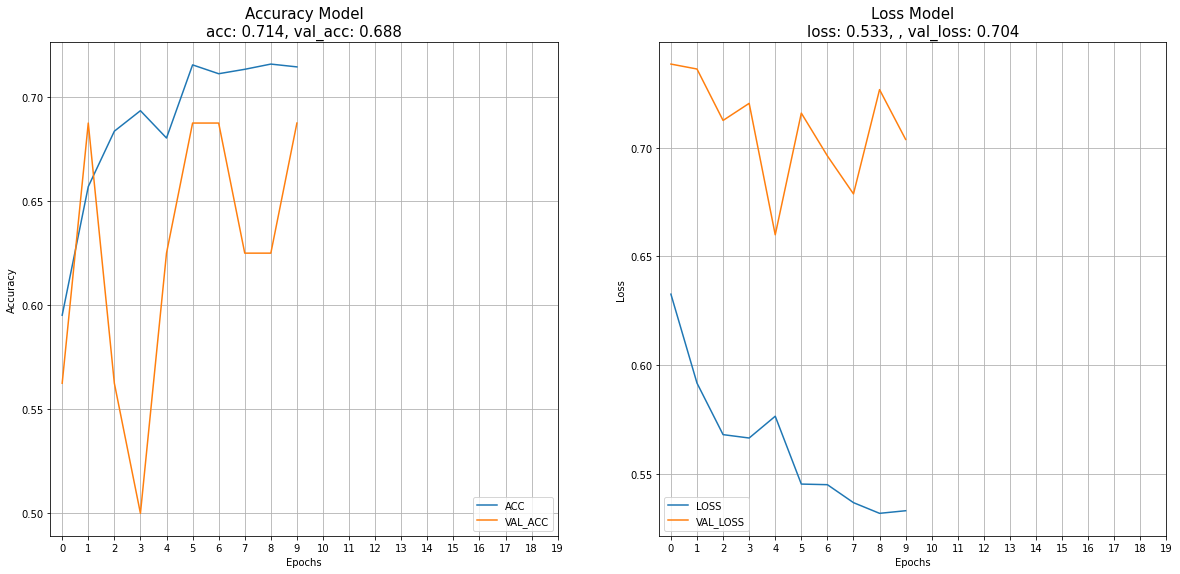

In [ ]:
acc_loss_plot(tnsf_history, epochs)

### True Negatives: 167

### False Positives: 67

### False Negatives: 73

### True Positives: 317

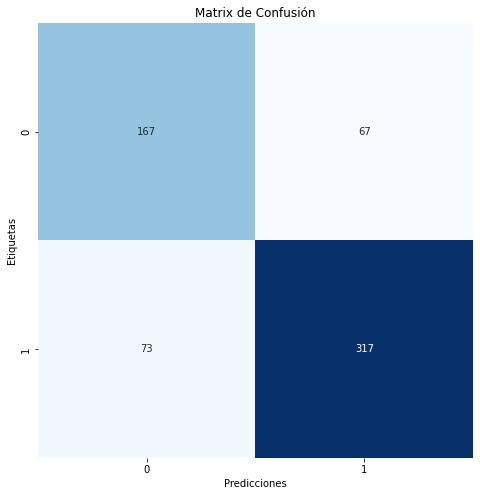


               precision    recall  f1-score   support

           0       0.70      0.71      0.70       234
           1       0.83      0.81      0.82       390

    accuracy                           0.78       624
   macro avg       0.76      0.76      0.76       624
weighted avg       0.78      0.78      0.78       624



In [ ]:
normal_count = len(os.listdir(TEST_PATH + '/NORMAL'))
pneu_count = len(os.listdir(TEST_PATH + '/PNEUMONIA'))
predictions = tnsf_model.predict(test_ds_aug, (normal_count + pneu_count) // batch_size+1)
report(predictions, test_ds_aug.classes)

In [ ]:
# Function to load images with the option of augment data
def img_generator_to_transfer(batch_size, transformations=False):
    test_datagen = ImageDataGenerator()
    val_datagen = ImageDataGenerator()
    
    if transformations:
      train_datagen = ImageDataGenerator(zoom_range=[0.5, 1.5], 
                                         brightness_range=[0.3, 1.5],
                                         horizontal_flip=True,
                                         vertical_flip=True,
                                         channel_shift_range=0.8)
    else:
      train_datagen = ImageDataGenerator()

    train_ds = train_datagen.flow_from_directory(TRAIN_PATH, 
                                                 class_mode='categorical', 
                                                 target_size=(256, 256),
                                                 color_mode='rgb',
                                                 batch_size=batch_size,
                                                 shuffle=True,
                                                 seed=42)
    
    valid_ds = val_datagen.flow_from_directory(VALID_PATH, 
                                               class_mode='categorical', 
                                               target_size=(256, 256),
                                               color_mode='rgb',
                                               batch_size=batch_size)
    
    test_ds = test_datagen.flow_from_directory(TEST_PATH, 
                                               class_mode='categorical', 
                                               color_mode='rgb',
                                               target_size=(256, 256),
                                               batch_size=batch_size,
                                               shuffle=False)
    return train_ds, valid_ds, test_ds, train_ds.class_indices

In [ ]:
train_ds_aug, valid_ds_aug, test_ds_aug, _ = img_generator_to_transfer(32, transformations=True)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [ ]:
from tensorflow.keras.applications.efficientnet import EfficientNetB7
from tensorflow.keras.layers import Input, GlobalAveragePooling2D
from tensorflow.keras import Model
base_model = EfficientNetB7(include_top=False,  input_shape=(256, 256, 3))
base_model.trainable = False

258088960/258076736 [==============================] - 1s 0us/step


In [ ]:
inputs = Input(shape=(256, 256, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(2, activation='softmax')(x)

tnsf_model = Model(inputs, outputs)

In [ ]:
tnsf_model.compile(optimizer=RMSprop(0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

tnsf_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 efficientnetb7 (Functional)  (None, 8, 8, 2560)       64097687  
                                                                 
 global_average_pooling2d (G  (None, 2560)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               1311232   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 1026      
                                                             

In [ ]:
epochs = 25

train_steps = train_ds.n // train_ds.batch_size

early_stopping = EarlyStopping(
                        monitor='val_loss',
                        mode='min', min_delta=0.002, 
                        patience=5, verbose=True, 
                        restore_best_weights=True)

tb_callback = TensorBoard('./logs', update_freq=1)

last_epoch = early_stopping.stopped_epoch if early_stopping.stopped_epoch != 0 else epochs

tnsf_history = tnsf_model.fit(train_ds_aug, epochs=epochs, 
                        validation_data=test_ds_aug, 
                        steps_per_epoch=train_steps,
                        callbacks=[early_stopping, tb_callback],
                        class_weight=class_weights)

Epoch 1/25
144/144 [==============================] - 201s 1s/step - loss: 0.3723 - accuracy: 0.8357 - val_loss: 0.4247 - val_accuracy: 0.8029
Epoch 2/25
144/144 [==============================] - 160s 1s/step - loss: 0.2689 - accuracy: 0.8904 - val_loss: 0.3091 - val_accuracy: 0.8654
Epoch 3/25
144/144 [==============================] - 154s 1s/step - loss: 0.2333 - accuracy: 0.9026 - val_loss: 0.3731 - val_accuracy: 0.8269
Epoch 4/25
144/144 [==============================] - 155s 1s/step - loss: 0.2196 - accuracy: 0.9091 - val_loss: 0.2520 - val_accuracy: 0.9006
Epoch 5/25
144/144 [==============================] - 155s 1s/step - loss: 0.2092 - accuracy: 0.9149 - val_loss: 0.2807 - val_accuracy: 0.8766
Epoch 6/25
144/144 [==============================] - 154s 1s/step - loss: 0.2025 - accuracy: 0.9221 - val_loss: 0.2698 - val_accuracy: 0.8750
Epoch 7/25
144/144 [==============================] - 151s 1s/step - loss: 0.1886 - accuracy: 0.9232 - val_loss: 0.2921 - val_accuracy: 0.8814

In [ ]:
tnsf_model.evaluate(valid_ds_aug)

In [ ]:
acc_loss_plot(tnsf_history, last_epoch)

In [ ]:
normal_count = len(os.listdir(VALID_PATH + '/NORMAL'))
pneu_count = len(os.listdir(VALID_PATH + '/PNEUMONIA'))
predictions = tnsf_model.predict(valid_ds_aug, (normal_count + pneu_count) // batch_size+1)
report(predictions, valid_ds_aug.classes)

In [ ]:
model.save('/content/drive/MyDrive/TrainedModels/my_model.h5') 

#### Fine tunning

In [ ]:
base_model.trainable = True

train_ds_aug.reset()
valid_ds_aug.reset()

tnsf_model.compile(optimizer=RMSprop(1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

tnsf_history = tnsf_model.fit(train_ds_aug, epochs=10, 
                        validation_data=valid_ds_aug, 
                        steps_per_epoch=train_steps,
                        callbacks=[early_stopping],
                        class_weight=class_weights)

In [ ]:
last_epoch = early_stopping.stopped_epoch if early_stopping.stopped_epoch != 0 else 10
acc_loss_plot(tnsf_history, last_epoch)

In [ ]:
tnsf_model.evaluate(test_ds_aug)

In [ ]:
normal_count = len(os.listdir(TEST_PATH + '/NORMAL'))
pneu_count = len(os.listdir(TEST_PATH + '/PNEUMONIA'))
predictions = tnsf_model.predict(test_ds_aug, (normal_count + pneu_count) // batch_size+1)
report(predictions, test_ds_aug.classes)